In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png',}
import scienceplots

from sklearn import metrics, preprocessing, pipeline, model_selection, linear_model
import pandas as pd
import xgboost as xgb
from prophet import Prophet
#from sklearn_pandas import DataFrameMapper

from darts import TimeSeries
from darts.models import NBEATSModel, AutoARIMA
from darts.metrics import mape, r2_score
from darts.dataprocessing.transformers import MissingValuesFiller

pd.set_option('display.max_rows', 128)
pd.set_option('display.max_columns', 128)


def mean_percentage_error(A, F):
    A_abs, F_abs = np.abs(A), np.abs(F)
    mask = ~(np.maximum(A_abs, F_abs) == 0)
    return 100.0 * np.mean((np.abs(A - F) / np.maximum(A_abs, F_abs))[mask])

In [2]:
def monthly_plot(data: pd.DataFrame, key:str, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data[(data.index.year == year) & (data.index.month == month)]

    array = np.full(shape=(32, 24), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.day, ts.hour] = item[key]

    ax.imshow(array.T, cmap='magma', vmin=vmin, vmax=vmax, interpolation='none', aspect='auto')
    #ax.set_xlim(0.5, 31.5)

    ax.grid(False)

    # Invert the vertical axis
    #ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)


def weekly_plot(daily_data: pd.DataFrame, key: str, year:int, ax):
    data = daily_data

    assert isinstance(data.index, pd.DatetimeIndex)
    # new_index = pd.date_range(start=f'{data.index.year.min()}-01-01', end=f'{data.index.year.max()+1}-01-01', freq='1D', tz=data.index.tz)
    # data = data.reindex(new_index)

    data = data[(data.index.year == year)]

    # Lets figure out the size of array
    n_weeks = data.index.isocalendar().week.unique().max() + 1
    n_days = 7

    # Sorry. I couldn't find more efficient way to do it.
    array = np.full(shape=(n_weeks, n_days), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.week, ts.dayofweek] = item[key]

    ax.imshow(array.T, cmap='magma', interpolation='none')

    ax.set_xlim(0.5, n_weeks)

    ax.grid(False)

    weekdays = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
    ax.set_yticks(range(7), weekdays)

    ax.set_xlabel('week number')

    # # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # # Remove all spines
    ax.set_frame_on(False)


In [3]:

df = pd.read_parquet('../../data/uciml-dataset-hourly.parquet')
df.head().T

timestamp,2006-12-16 17:00:00+01:00,2006-12-16 18:00:00+01:00,2006-12-16 19:00:00+01:00,2006-12-16 20:00:00+01:00,2006-12-16 21:00:00+01:00
global_active_power,2533.733333,3632.2,3400.233333,3268.566667,3056.466667
global_reactive_power,137.4,80.033333,85.233333,75.1,76.666667
sub_metering_1,0.0,0.0,0.0,0.0,0.0
sub_metering_2,19.0,403.0,86.0,0.0,25.0
sub_metering_3,607.0,1012.0,1001.0,1007.0,1033.0
unmetered,1907.733333,2217.2,2313.233333,2261.566667,1998.466667
voltage,234.643889,234.580167,233.2325,234.0715,237.158667
global_intensity,18.1,15.6,14.503333,13.916667,13.046667
country,France,France,France,France,France
region,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux


In [4]:
df.timestamp.head(5)

timestamp
2006-12-16 17:00:00+01:00   2006-12-16 17:00:00+01:00
2006-12-16 18:00:00+01:00   2006-12-16 18:00:00+01:00
2006-12-16 19:00:00+01:00   2006-12-16 19:00:00+01:00
2006-12-16 20:00:00+01:00   2006-12-16 20:00:00+01:00
2006-12-16 21:00:00+01:00   2006-12-16 21:00:00+01:00
Name: timestamp, dtype: datetime64[ns, pytz.FixedOffset(60)]

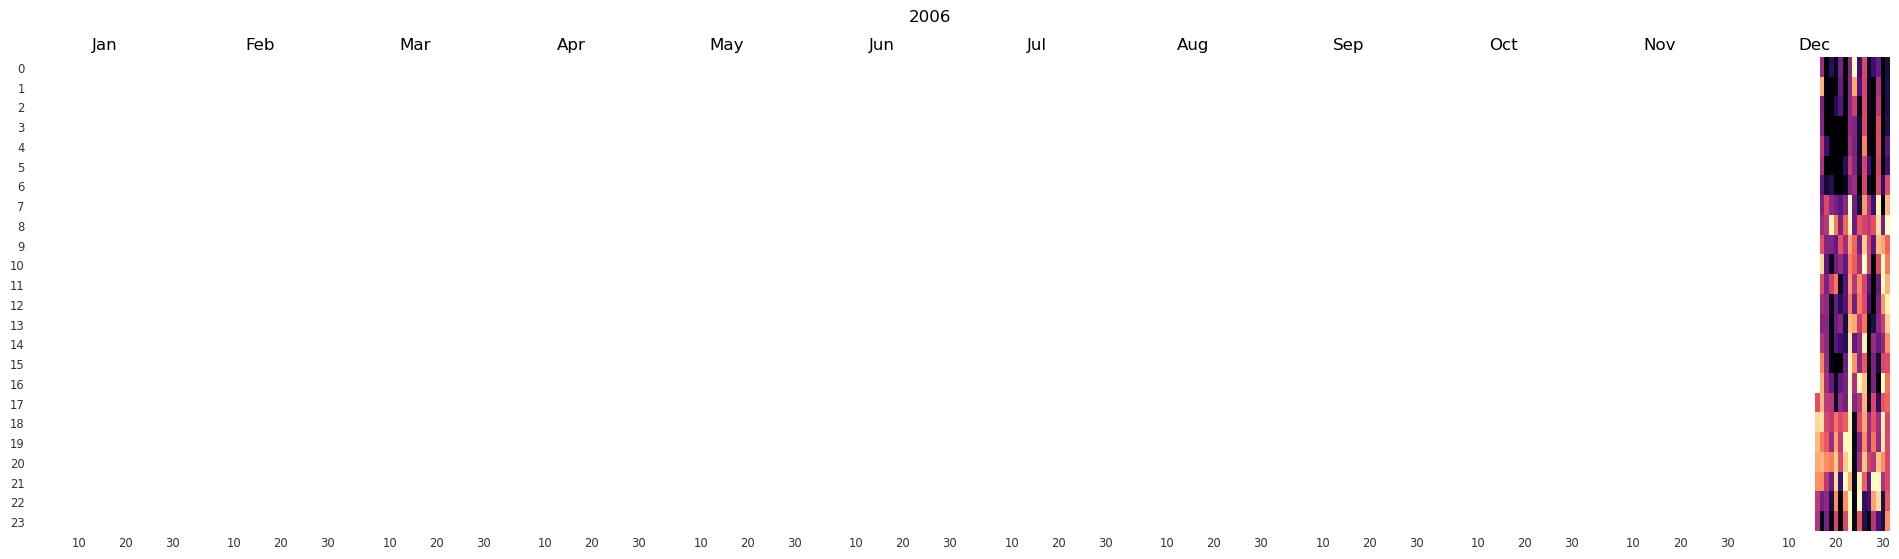

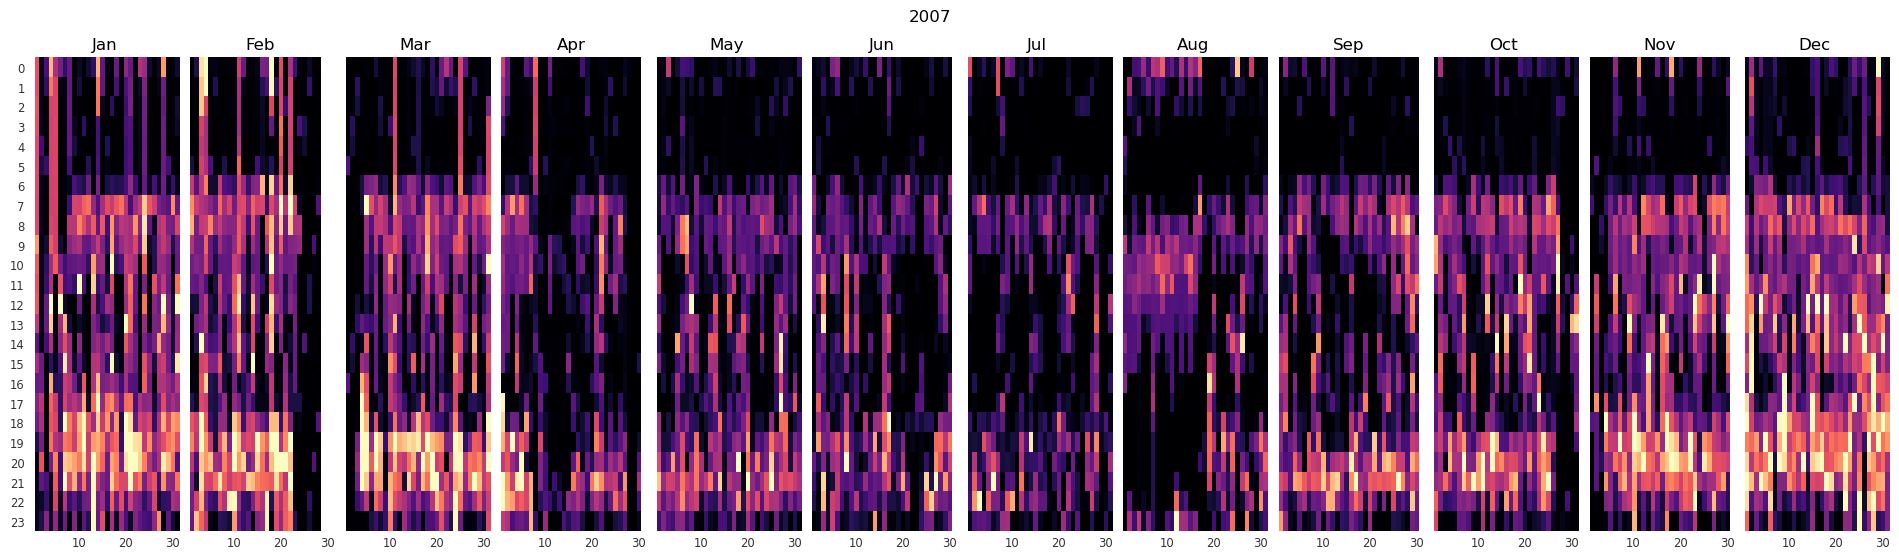

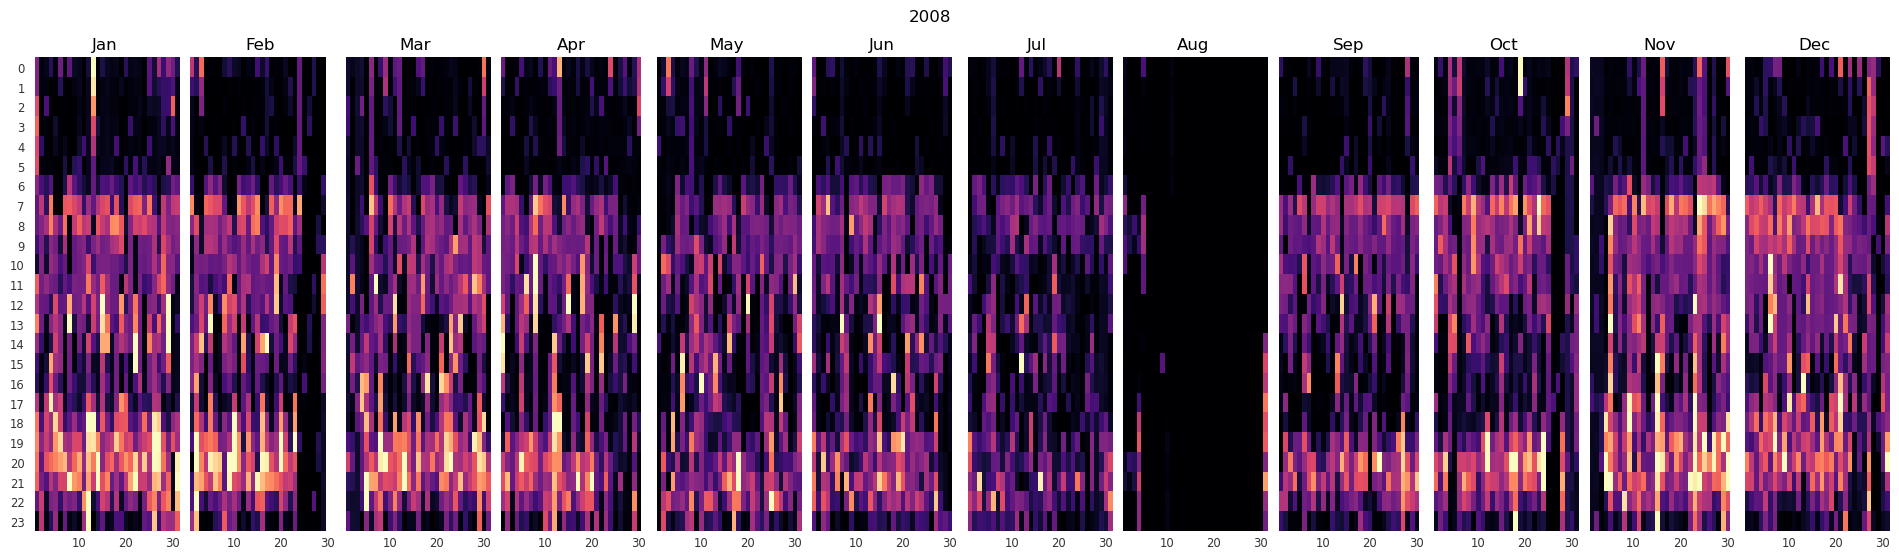

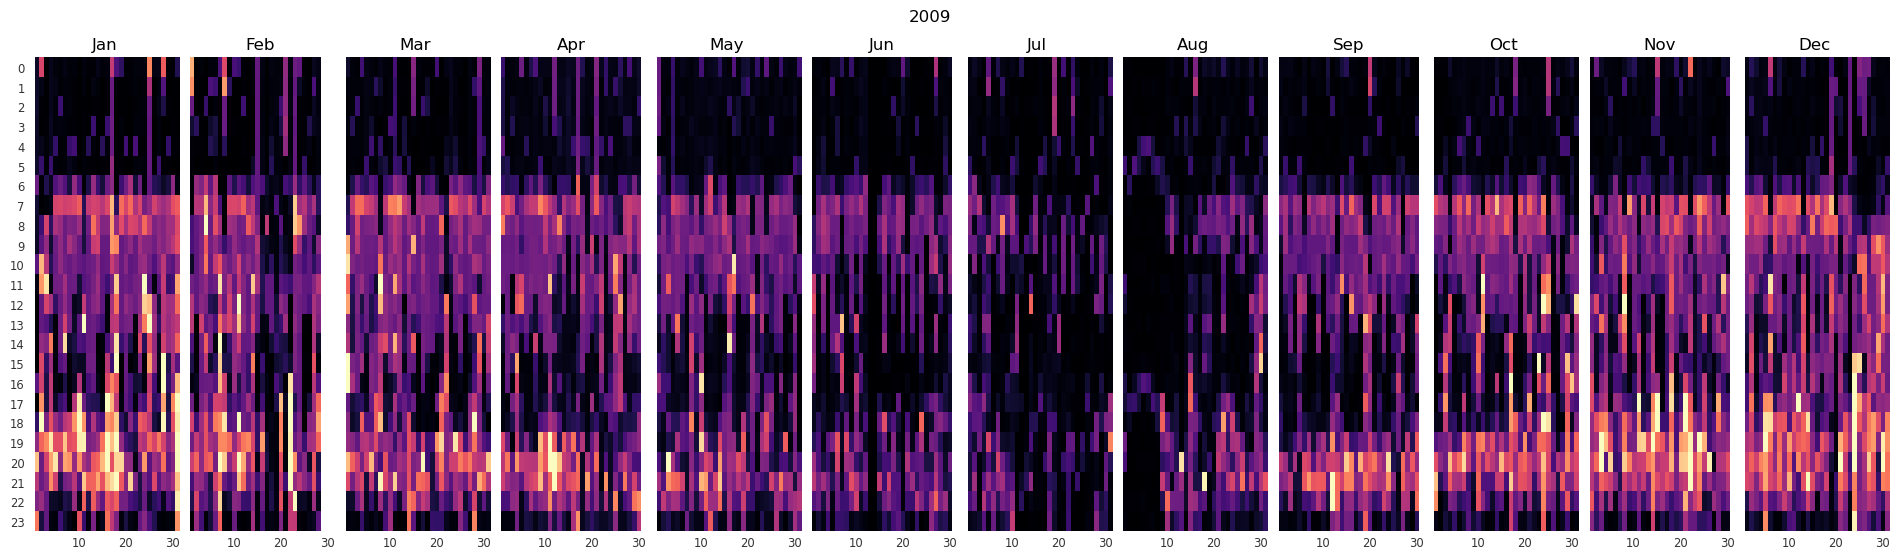

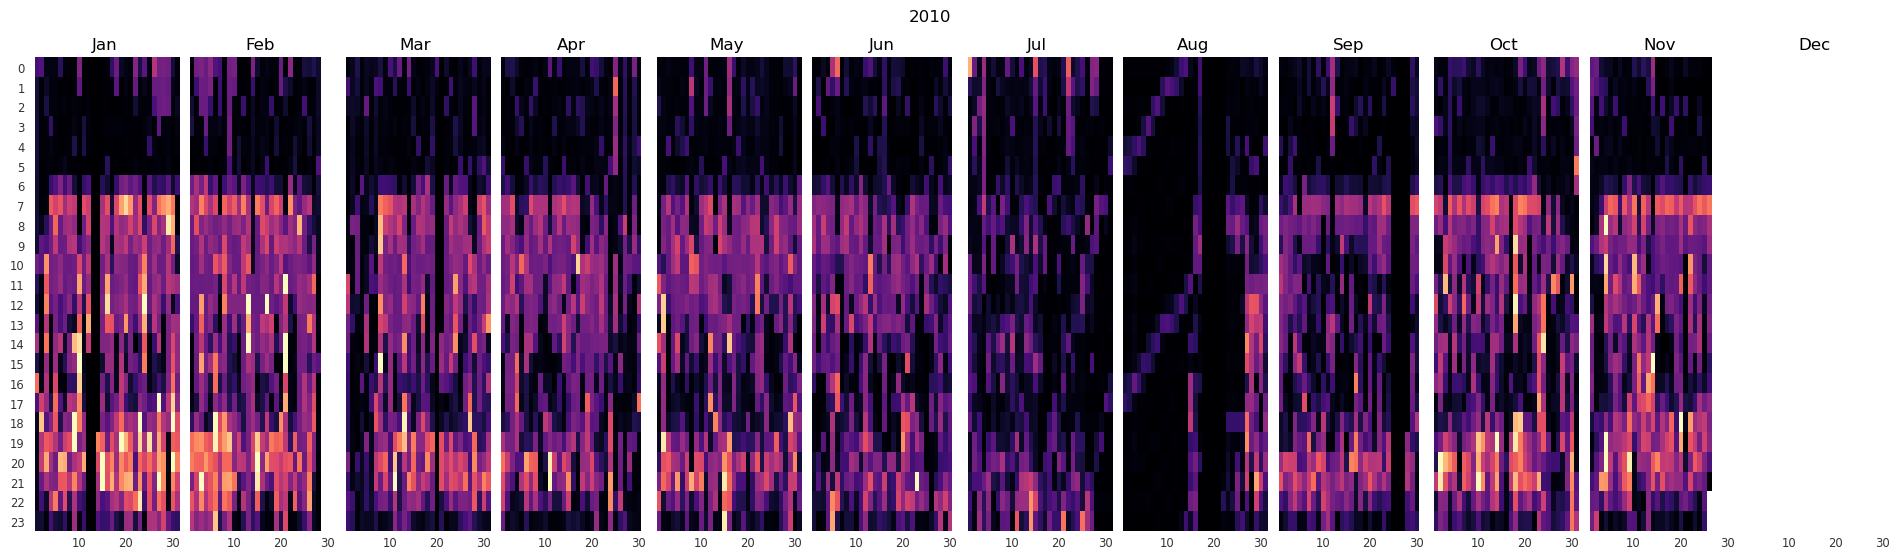

In [5]:

key = 'global_active_power'

view = df.copy()
view = view.set_index('timestamp')

#view = view[[key]].resample('1H').sum()

vmin, vmax = view[key].quantile(0.1), view[key].quantile(0.99)

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(view.index.year.unique()):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)

    fig.suptitle(year)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(view, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

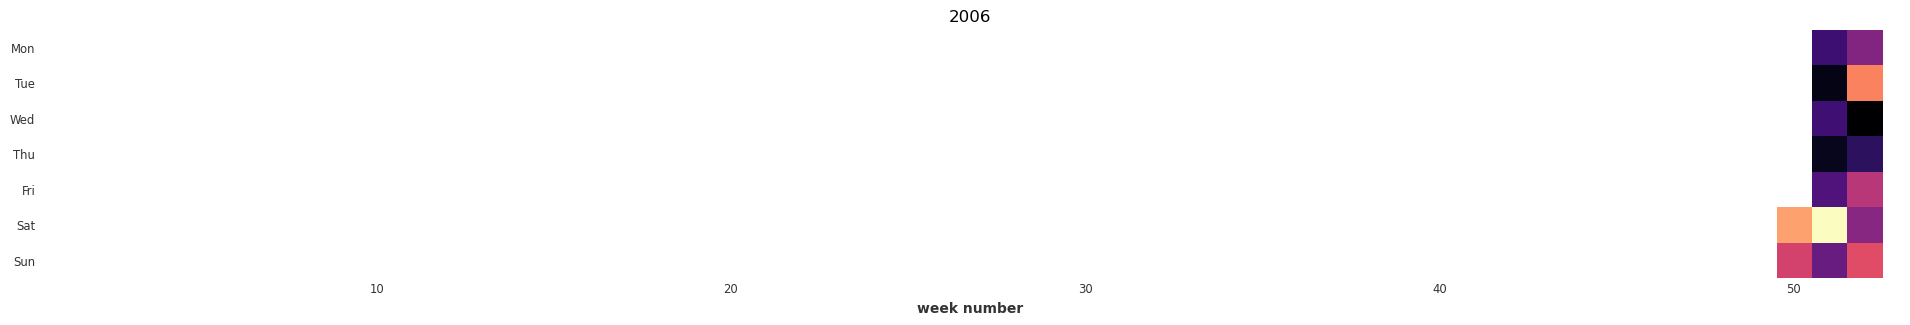

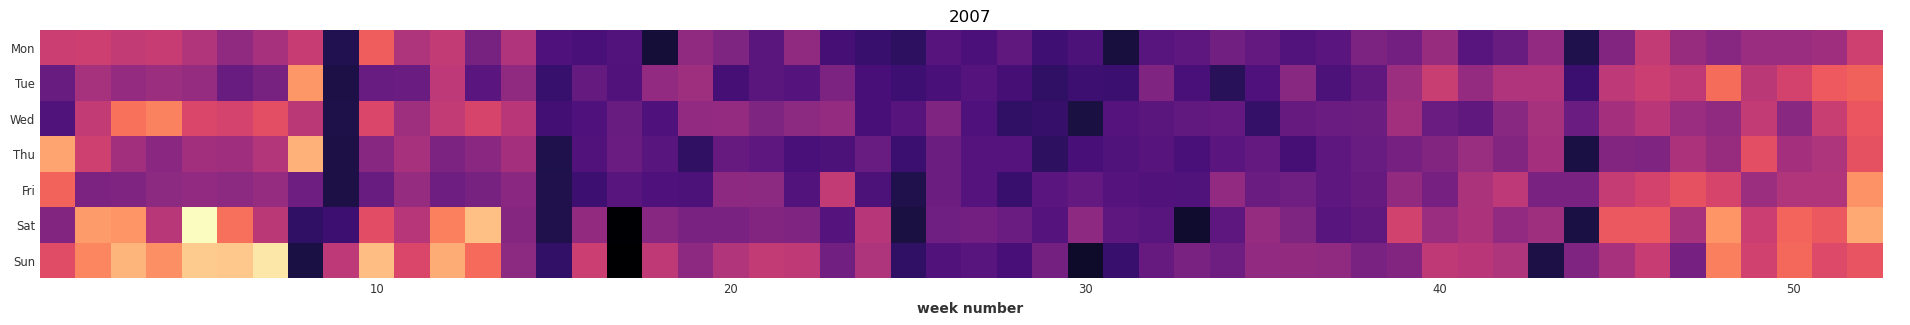

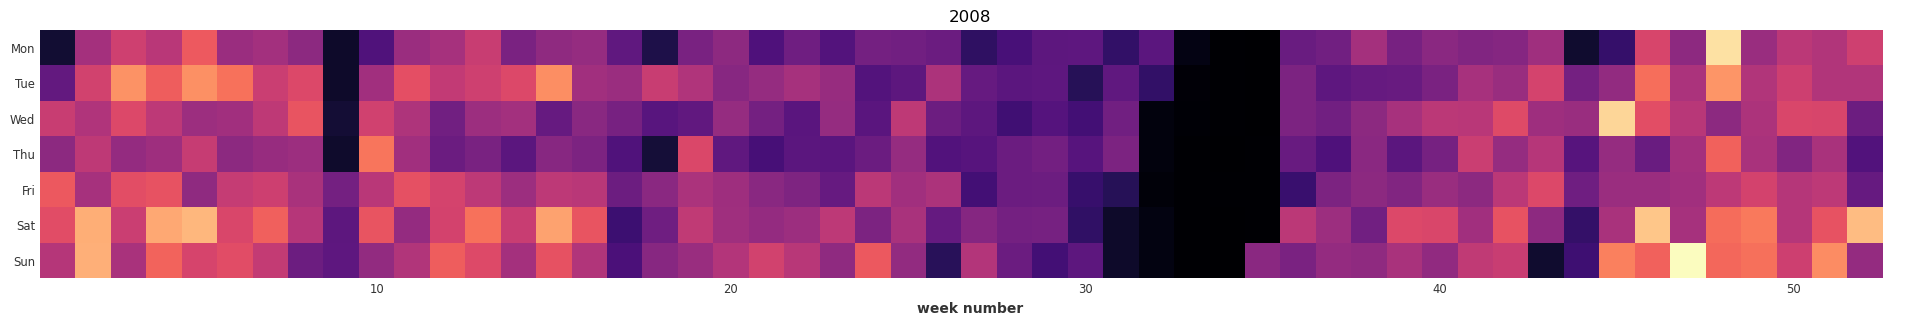

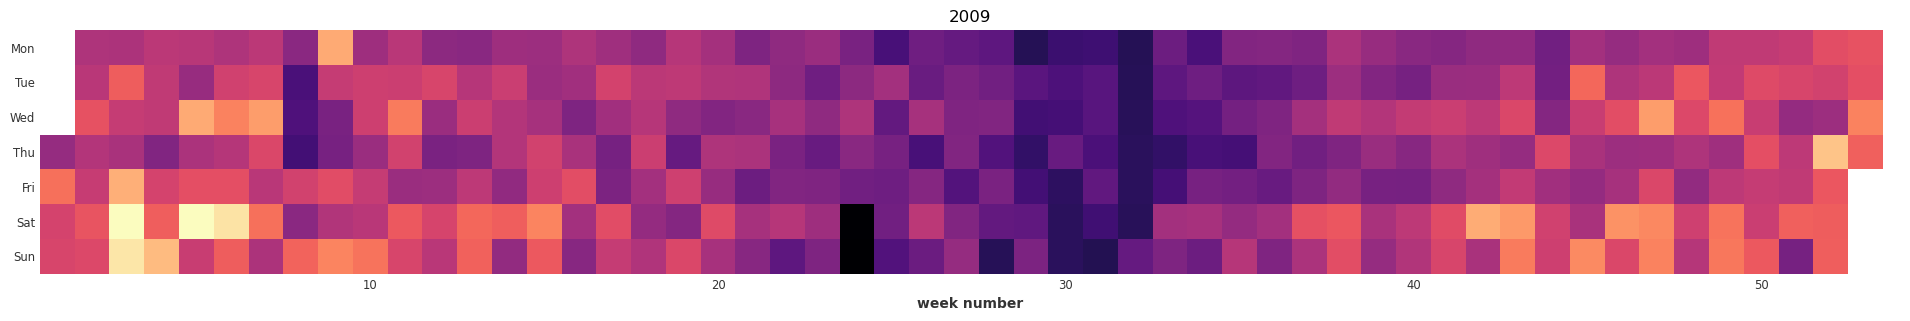

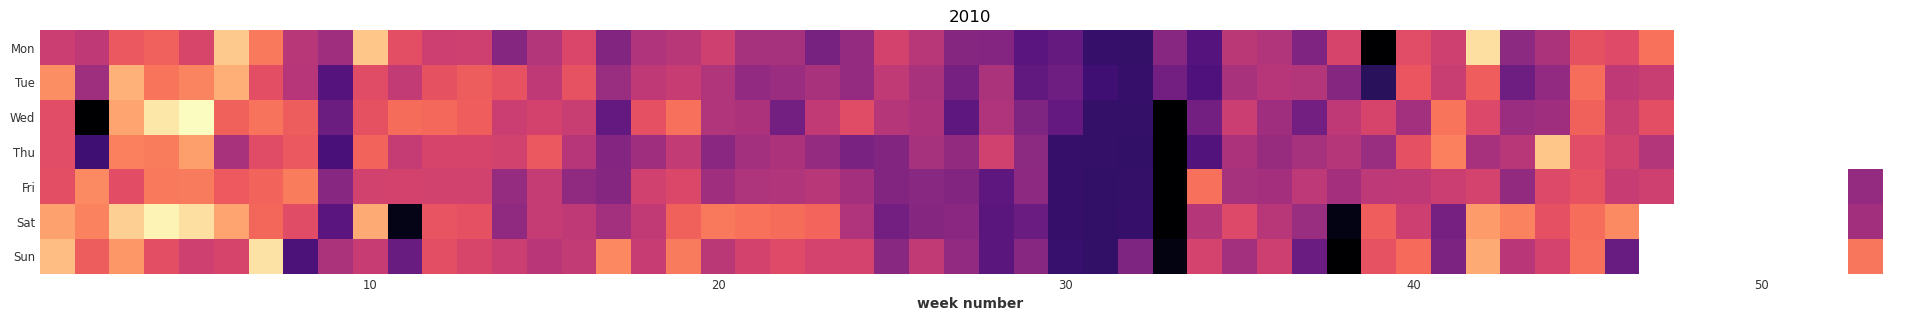

In [6]:
key = 'global_active_power'

view = df.copy()
view = view.set_index('timestamp').sort_index()
view = view[[key]].resample('1D').sum(min_count=1)

vmin, vmax = view[key].quantile(0.1), view[key].quantile(0.99)

view = df.copy()
view = view.sort_index()
view = view[[key]].resample('1D').mean()

for i, year in enumerate(view.index.year.unique()):
    fig, axes = plt.subplots(figsize=(20, 6))
    weekly_plot(view, key, year, axes)

    axes.set_title(year)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

In [7]:
# Somehow express the activity of the user. First and last active hour of the day
#firsts = df[df.sub_metering_1 > 0].groupby(df.timestamp.dt.date).nth(0)[['timestamp', 'sub_metering_1']]
#lasts = df[df.sub_metering_1 > 0].groupby(df.timestamp.dt.date).nth(-1)[['timestamp', 'sub_metering_1']]

# convert Wh --> kWh
for col in ['global_active_power', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'unmetered']:
    df[col] = df[col] / 1000.0


# Social activities
df['kitchen_activity'] = df.sub_metering_1 > 0

# Energy spent today (don't use because it leaks data. Discard after done)
for _, group in df.groupby(df.timestamp.dt.date):
    daily_total = group['global_active_power'].sum()
    df.loc[group.index, 'daily_ratio'] = group['global_active_power'] / daily_total

    df.loc[group.index, 'today_median_energy'] = group['global_active_power'].median()

# energy consumption 1 day ago, 1 week ago
df['yesterday_ratio'] = df['daily_ratio'].shift(24)
df['yesterday_ratio_ahead'] = df['daily_ratio'].shift(24 - 1)
df['last_week_ratio'] = df['daily_ratio'].shift(24 * 7)
df['last_week_ratio_ahead'] = df['daily_ratio'].shift(24 * 7 - 1)

df['yesterday_median_energy'] = df['today_median_energy'].shift(24)


df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)


# Behavioral features based on hour ranges
# 6 - 9 breakfast
df['breakfast_6_9'] = (df.timestamp.dt.hour >= 6) & (df.timestamp.dt.hour < 9)
# 11 - 16 lunch
df['lunch_11_15'] = (df.timestamp.dt.hour >= 11) & (df.timestamp.dt.hour < 16)
# 18 - 21 dinner
df['dinner_18_21'] = (df.timestamp.dt.hour >= 18) & (df.timestamp.dt.hour < 21)
# 22 - 7 sleep
df['sleep_22_7'] = (df.timestamp.dt.hour >= 22) | (df.timestamp.dt.hour <= 6)
# 9 - 17 work hours
df['work_9_17'] = (df.timestamp.dt.hour >= 9) & (df.timestamp.dt.hour < 17)

df['freetime_17_22'] = (df.timestamp.dt.hour >= 17) & (df.timestamp.dt.hour < 22)

# Is daylight saving time
df['is_dst'] = df.timestamp.map(lambda x : int(x.dst().total_seconds() != 0)).astype(bool)

# New Behavioral features (house activity)
df['house_activity'] = False
df.loc[(df.timestamp.dt.hour >= 6) & (df.timestamp.dt.hour <= 23), 'house_activity'] = True

In [8]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

df.dtypes

global_active_power                                     float64
global_reactive_power                                   float64
sub_metering_1                                          float64
sub_metering_2                                          float64
sub_metering_3                                          float64
unmetered                                               float64
voltage                                                 float64
global_intensity                                        float64
country                                                category
region                                                 category
lat                                                     float64
lon                                                     float64
tz                                                     category
timestamp                  datetime64[ns, pytz.FixedOffset(60)]
is_holiday                                                 bool
weekday                                 

In [9]:
df.tail().T

timestamp,2010-11-26 17:00:00+01:00,2010-11-26 18:00:00+01:00,2010-11-26 19:00:00+01:00,2010-11-26 20:00:00+01:00,2010-11-26 21:00:00+01:00
global_active_power,1.7259,1.573467,1.659333,1.1637,0.046733
global_reactive_power,61.4,53.7,60.033333,61.166667,0.0
sub_metering_1,0.0,0.0,0.0,0.0,0.0
sub_metering_2,0.0,0.0,0.004,0.064,0.0
sub_metering_3,0.772,0.0,0.0,0.0,0.0
unmetered,0.9539,1.573467,1.655333,1.0997,0.046733
voltage,237.069667,237.531833,236.741,239.396,239.69
global_intensity,7.216667,6.62,7.056667,4.913333,3.8
country,France,France,France,France,France
region,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux


In [10]:
ts_columns = df.columns.to_list()[:8]

df['prediction_1h_ahead'] = df['global_active_power'].shift(-1) # / 1000.0 # Convert Wh --> kWh
df['prediction_3h_ahead'] = df['global_active_power'].rolling(3).sum().shift(-3)


for col in ts_columns:
    df[f'{col}_mean_3h'] = df[col].rolling(3).mean()
    df[f'{col}_std_3h'] = df[col].rolling(3).std()

    df[f'{col}_yesterday'] = df[col].shift(24)
    df[f'{col}_yesterday_ahead'] = df[col].shift(24 - 1)

    df[f'{col}_last_week'] = df[col].shift(24 * 7)
    df[f'{col}_last_week_ahead'] = df[col].shift(24 * 7 - 1)

df.head().T

timestamp,2006-12-16 17:00:00+01:00,2006-12-16 18:00:00+01:00,2006-12-16 19:00:00+01:00,2006-12-16 20:00:00+01:00,2006-12-16 21:00:00+01:00
global_active_power,2.533733,3.6322,3.400233,3.268567,3.056467
global_reactive_power,137.4,80.033333,85.233333,75.1,76.666667
sub_metering_1,0.0,0.0,0.0,0.0,0.0
sub_metering_2,0.019,0.403,0.086,0.0,0.025
sub_metering_3,0.607,1.012,1.001,1.007,1.033
unmetered,1.907733,2.2172,2.313233,2.261567,1.998467
voltage,234.643889,234.580167,233.2325,234.0715,237.158667
global_intensity,18.1,15.6,14.503333,13.916667,13.046667
country,France,France,France,France,France
region,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux


In [11]:
from pprint import pprint

domain_features = {
    #'PVs': [],
    #'EVs': [],
    'measurements': sorted([
        name for name in df.columns
        if ('power' in name) or ('meter' in name) or ('volt' in name) or ('intensity' in name)
    ])
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'region', 'country'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': [name for name in df.columns if name.startswith('solar_')],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend'],
    'cooking': ['kitchen_activity'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'last_week_ratio', 'last_week_ratio_ahead', 'yesterday_median_energy', 'house_activity',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    #["tz", 'region', "country", "timestamp"] + # useless in our case because it is constant
    ['prediction_1h_ahead', 'prediction_3h_ahead',]
)

# Check for missed features #1, #2, and duplicates
set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1])



== Domain Specific Features ==
{'measurements': ['global_active_power',
                  'global_active_power_last_week',
                  'global_active_power_last_week_ahead',
                  'global_active_power_mean_3h',
                  'global_active_power_std_3h',
                  'global_active_power_yesterday',
                  'global_active_power_yesterday_ahead',
                  'global_intensity',
                  'global_intensity_last_week',
                  'global_intensity_last_week_ahead',
                  'global_intensity_mean_3h',
                  'global_intensity_std_3h',
                  'global_intensity_yesterday',
                  'global_intensity_yesterday_ahead',
                  'global_reactive_power',
                  'global_reactive_power_last_week',
                  'global_reactive_power_last_week_ahead',
                  'global_reactive_power_mean_3h',
                  'global_reactive_power_std_3h',
                  'global

(set(), set(), set())

In [12]:
domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]

In [13]:
df.to_parquet('../../data/uciml-dataset-hourly.complete.parquet')

In [36]:
from sklearn import ensemble, tree, model_selection, neural_network, compose


mapper = compose.make_column_transformer(
    ('drop', compose.make_column_selector(dtype_include=['datetime', 'datetimetz'])),
    (preprocessing.OneHotEncoder(sparse_output=False), compose.make_column_selector(dtype_include=['category', 'object'])),
    n_jobs=8,
    remainder='passthrough',
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')

regr = pipeline.make_pipeline(
    mapper,
    #linear_model.LinearRegression(n_jobs=-1),
    xgb.XGBRegressor(n_jobs=-1, random_state=42),
    #neural_network.MLPRegressor(max_iter=500, learning_rate='adaptive', random_state=42),
    verbose=False
)

prediction = 'prediction_1h_ahead'

used_features = []

#used_features = ['global_active_power', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'unmetered', 'voltage']

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

# Remove data collected from submeters
keywords = ('meter', 'volt', 'kitchen', 'breakfast', 'dinner', 'lunch', 'sleep', 'work', 'freetime',)
for keyword in keywords:
    used_features = list(filter(lambda x: keyword not in x, used_features))

for col in ('region', 'tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)

_df = df[[prediction, *used_features]].copy().reset_index(drop=True).dropna()

X, y = _df[used_features], _df[prediction]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, shuffle=False)

y_pred = regr.fit(X_train, y_train).predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)


print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-19 -- MLP')

& 0.252 & 27.846  % 2023-04-19 -- MLP


MSE = 0.252kWh
LogAcc = nan
MAPE = 24,387.273%
R2 = 0.55557
sMAPE = 35.601%
MAAPE = 35.363%
relative error = 27.846%
Carolina = 72.580%
Blaz = 17.144%


invalid value encountered in log


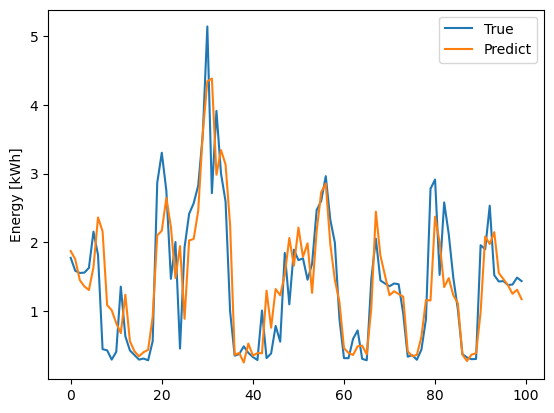

In [37]:
#y_test = y_test.to_numpy()
_y_true = y_test.to_numpy()
_y_pred = y_pred

def sMAPE(A, F):
    return 100.0 / len(A) * np.sum(2 * np.abs(F - A) / np.maximum(np.abs(A) + np.abs(F), np.finfo(float).eps))

def log_accuracy(A, F):
    return np.mean(np.log(F / (A + np.finfo(float).eps)))

def mean_absolute_percentage_error(A, F):
    return 100.0 / len(A) * np.sum(np.abs(A - F) / np.maximum(A, 1e-6))

# MAAPE
def MAAPE(A, F):
    return 100.0 * np.mean(np.arctan(np.abs(A - F) / (A + np.finfo(float).eps)))

def relative_error(A, F):
    return 100.0 * np.mean(np.abs(A - F) / np.maximum(A, F))

def carolina_err_func(A, F):
    top = 1 + np.abs(A - F)
    bottom = 1 + np.abs(A)
    return 100.0  / len(A) * np.sum(top / bottom)


def blaz_err_func(A, F):
    return 100.0 * np.mean(np.abs(A - F) / (1 + np.abs(A)))

mape = mean_absolute_percentage_error(_y_true, _y_pred)
mse = metrics.mean_squared_error(_y_true, _y_pred)
r2 = metrics.r2_score(_y_true, _y_pred)
smape = sMAPE(_y_true, y_pred)
log_acc = log_accuracy(_y_true, _y_pred)
rel_err = relative_error(_y_true, _y_pred)
maape = MAAPE(_y_true, _y_pred)
cfe = carolina_err_func(_y_true, _y_pred)
bb = blaz_err_func(_y_true, _y_pred)

print(
    f'MSE = {mse:,.3f}kWh\n'
    f'LogAcc = {log_acc:,.3f}\n'
    f'MAPE = {mape:,.3f}%\n'
    f'R2 = {r2:,.5f}\n'
    f'sMAPE = {smape:,.3f}%\n'
    f'MAAPE = {maape:,.3f}%\n'
    f'relative error = {rel_err:,.3f}%\n'
    f'Carolina = {cfe:,.3f}%\n'
    f'Blaz = {bb:,.3f}%'
)

plt.plot(_y_true[:100], label='True')
plt.plot(_y_pred[:100], label='Predict')
plt.ylabel('Energy [kWh]')
plt.legend()
plt.show()

In [38]:
import shap

_X = mapper.fit_transform(X)

# Rename columns to to show what group in belongs
rename = {}
for col in _X.columns:
    for sample in domain_features:
        if col.startswith(sample):
            rename[col] = f'{col} (D)'

    for sample in contextual_features:
        if col.startswith(sample):
            rename[col] = f'{col} (C)'

    for sample in behavioral_features:
        if col.startswith(sample):
            rename[col] = f'{col} (B)'

_X.rename(columns=rename, inplace=True)
model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
model.fit(_X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(_X)
#clustering = shap.utils.hclust(_X, y)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


{'D': 21, 'C': 9, 'B': 9} 39


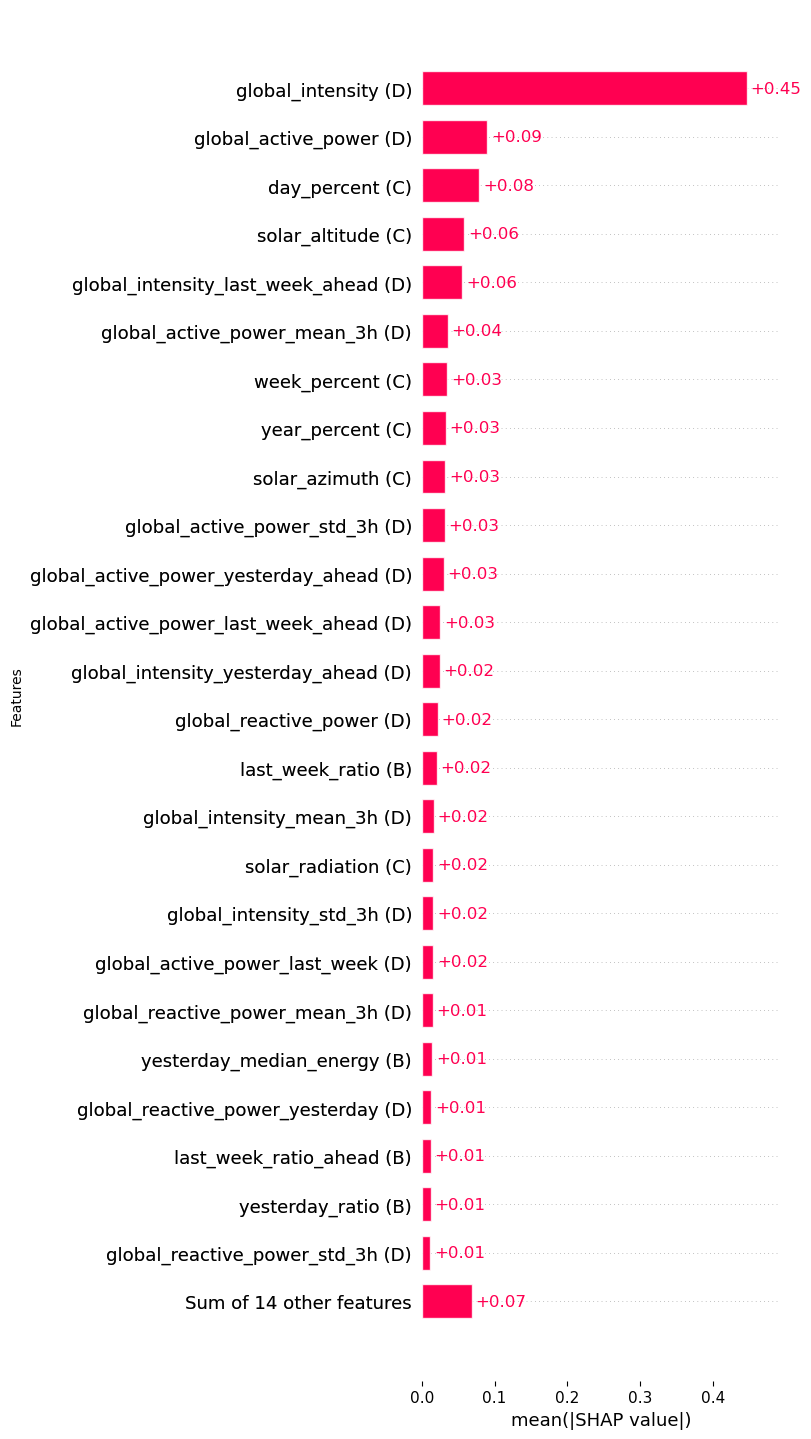

In [40]:
# visualize all the training set predictions
count = {'D': 0, 'C': 0, 'B': 0}
for feature in _X.columns:
    if feature.endswith('(D)'):
        count['D'] += 1
    elif feature.endswith('(C)'):
        count['C'] += 1
    elif feature.endswith('(B)'):
        count['B'] += 1

print(count, len(_X.columns))


plt.rcdefaults()
# visualize all the training set predictions

#shap.plots.beeswarm(shap_values, max_display=25+1, show=False)
shap.plots.bar(
    shap_values,
    max_display=25+1, #len(_X.columns),
    show=False,
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [41]:
total_sum = {'D': 0, 'C': 0, 'B': 0}
count = {'D': 0, 'C': 0, 'B': 0}

print(shap_values.values.shape)

for feature, value in zip(_X.columns, np.mean(np.abs(shap_values.values), axis=0)):
    if feature.endswith('(D)'):
        total_sum['D'] += value
        count['D'] += 1

    elif feature.endswith('(C)'):
        total_sum['C'] += value
        count['C'] += 1

    elif feature.endswith('(B)'):
        total_sum['B'] += value
        count['B'] += 1

    #if value > 0.41:
    #    print(feature, value)

# Normalize
average = { key: (total_sum[key] / count[key]) for key in ['D', 'C', 'B'] }

print(count, sum(count.values()))
print(total_sum)
print(average)

(33405, 39)
{'D': 21, 'C': 9, 'B': 9} 39
{'D': 0.9048156458884478, 'C': 0.2527604829519987, 'B': 0.0712114661000669}
{'D': 0.04308645932802132, 'C': 0.028084498105777636, 'B': 0.007912385122229656}


In [42]:
total_sum = {'D': 0, 'C': 0, 'B': 0}
count = {'D': 0, 'C': 0, 'B': 0}

for feature, value in zip(_X.columns, np.sum(np.abs(shap_values.values), axis=0)):
    if feature.endswith('(D)'):
        total_sum['D'] += value
        count['D'] += 1

    elif feature.endswith('(C)'):
        total_sum['C'] += value
        count['C'] += 1

    elif feature.endswith('(B)'):
        total_sum['B'] += value
        count['B'] += 1

    #if value > 0.41:
    #    print(feature, value)

# Normalize
#average = { key: (total_sum[key] / count[key]) for key in ['D', 'C', 'B'] }
#print(average)


print(f'Total sum: D={total_sum["D"]:,.3f}\t C={total_sum["C"]:,.3f}\t B={total_sum["B"]:,.3f}')

denom = sum(total_sum.values()) / 100
print(f'Normalized: D={total_sum["D"] / denom * 100:,.3f}\t C={total_sum["C"] / denom * 100:,.3f}\t B={total_sum["B"] / denom * 100:,.3f}')

print(f'{total_sum["D"] / denom:,.1f} & {total_sum["C"] / denom:,.1f} & {total_sum["B"] / denom:,.1f} \\\\')
#print(count, sum(count.values()))
#print(total_sum)
#print(average)

Total sum: D=30,225.367	 C=8,443.464	 B=2,378.819
Normalized: D=7,363.483	 C=2,056.991	 B=579.526
73.6 & 20.6 & 5.8 \\


In [51]:

used_features = []

#used_features = ['global_active_power', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'unmetered', 'voltage']

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

prediction = 'prediction_1h_ahead'

for col in ('region', 'tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)

# Remove data collected from submeters
keywords = ('meter', 'volt', 'kitchen', 'breakfast', 'dinner', 'lunch', 'sleep', 'work', 'freetime',)
for keyword in keywords:
    used_features = list(filter(lambda x: keyword not in x, used_features))

_df = df.copy()
_df.timestamp = _df.timestamp.dt.tz_localize(None)

dfp = _df[['timestamp', prediction, *used_features]].copy().reset_index(drop=True).dropna()
dfp.rename(columns={'timestamp': 'ds', prediction: 'y'}, inplace=True, errors='raise')

dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)

m = Prophet()

if 'is_holiday' in dfp_train.columns:
    print('Enable holidays')
    m.add_country_holidays(country_name='France')

for f in used_features:
    m.add_regressor(f)

forecast = m.fit(dfp_train).predict(dfp_test)

y_test = dfp_test['y'].to_numpy()
y_pred = forecast['yhat'].to_numpy()

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)


print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-19 -- Prophet')


Enable holidays


21:40:32 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing


& 0.252 & 30.002  % 2023-04-19 -- Prophet


In [ ]:
forecast.head(5).T

In [ ]:
# from neuralprophet import NeuralProphet

# used_features = []

# used_features += domain_features
# used_features += contextual_features
# used_features += behavioral_features

# prediction = 'prediction_1h_ahead'

# for col in ('region', 'tz', 'country', 'timestamp'):
#     if col in used_features:
#         used_features.remove(col)


# dfp = df[['timestamp', prediction, *used_features]].copy().reset_index(drop=True).dropna()
# dfp.rename(columns={'timestamp': 'ds', prediction: 'y'}, inplace=True, errors='raise')

# dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)


# m = NeuralProphet()

In [ ]:

#m.add_country_holidays(country_name='France')
#for f in used_features:
#    m.add_regressor(f)


#m.fit(dfp_train[['ds', 'y']], freq='H', validation_df=dfp_test[['ds', 'y']])
#forecast = m.predict(dfp_test[['ds', 'y']])

In [ ]:
from sklearn import neural_network

used_features = []

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

prediction = 'prediction_1h_ahead'

for col in ('region', 'tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)


df_train, df_test = model_selection.train_test_split(df, train_size=0.8, shuffle=False)


In [ ]:

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

used_features = []

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

prediction = 'prediction_1h_ahead'

for col in ('region', 'tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)


df_train, df_test = model_selection.train_test_split(df, train_size=0.8, shuffle=False)


series_train = TimeSeries.from_dataframe(df_train, 'timestamp', used_features, fill_missing_dates=True, fillna_value=None, freq='H')
series_train = MissingValuesFiller(n_jobs=-1).transform(series_train)

series_test = TimeSeries.from_dataframe(df_test, 'timestamp', used_features, freq='H')
series_test = MissingValuesFiller(n_jobs=-1).transform(series_train)


m = NBEATSModel(
    input_chunk_length=24*7,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=15, # was 30
    num_blocks=3, # default: 1; we selected 3
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0.1,
    activation='ReLU',
    n_epochs=300,
    nr_epochs_val_period=1,
    batch_size=360,
    model_name="nbeats_run",
    random_state=42,
    pl_trainer_kwargs=dict(
        accelerator='gpu', 
        devices=1, 
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, mode='min')
        ]
    ),
)

m.fit(series=series_train, val_series=series_test)
prediction = m.predict(len(series_test))


y_pred = prediction['global_active_power'].values()
y_true = series_test['global_active_power'].values()

assert len(y_pred) == len(y_true)

mape = metrics.mean_absolute_percentage_error(y_true + 1e-6, y_pred + 1e-6)
mse = metrics.mean_squared_error(y_true, y_pred)

print(f'{mape=} {mse=}')


In [ ]:
df[['timestamp']].head()

In [ ]:
df.timestamp.dt.tz_localize(None).head()